##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TF Lattice 집계 함수 모델

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/lattice/tutorials/aggregate_function_learning_models"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">}TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/lattice/tutorials/aggregate_function_models.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/lattice/tutorials/aggregate_function_models.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/lattice/tutorials/aggregate_function_models.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

## 개요

TFL 사전 제작된 집계 함수 모델은 복잡한 집계 함수를 학습하기 위해 TFL `tf.keras.model` 인스턴스를 구축하는 빠르고 쉬운 방법입니다. 이 가이드에서는 TFL 사전 제작된 집계 함수 모델을 구성하고 훈련/테스트하는 데 필요한 단계를 설명합니다. 

## 설정

TF Lattice 패키지 설치하기

In [2]:
#@test {"skip": true}
!pip install -q tensorflow-lattice pydot

필수 패키지 가져오기

In [3]:
import tensorflow as tf

import collections
import logging
import numpy as np
import pandas as pd
import sys
import tensorflow_lattice as tfl
logging.disable(sys.maxsize)

퍼즐 데이터세트 다운로드하기

In [4]:
train_dataframe = pd.read_csv(
    'https://raw.githubusercontent.com/wbakst/puzzles_data/master/train.csv')
train_dataframe.head()

puzzle_name  star_rating  word_count  is_amazon  includes_photo  \
0  NightHawks            5         108          1               0   
1  NightHawks            5          31          1               0   
2  NightHawks            5          51          1               0   
3  NightHawks            5          88          1               0   
4  NightHawks            4          37          1               0   

   num_helpful  Sales12-18MonthsAgo  
0            6                   81  
1            5                   81  
2            4                   81  
3            4                   81  
4            2                   81

In [5]:
test_dataframe = pd.read_csv(
    'https://raw.githubusercontent.com/wbakst/puzzles_data/master/test.csv')
test_dataframe.head()

puzzle_name  star_rating  word_count  is_amazon  includes_photo  \
0  NightHawks            4         138          0               0   
1  NightHawks            5         115          0               0   
2  NightHawks            5         127          0               0   
3  NightHawks            5         108          1               0   
4  NightHawks            5          31          1               0   

   num_helpful  SalesLastSixMonths  
0            0                  40  
1            0                  40  
2            0                  40  
3            6                  40  
4            5                  40

특성과 레이블 추출하기 및 변환하기

In [6]:
# Features:
# - star_rating       rating out of 5 stars (1-5)
# - word_count        number of words in the review
# - is_amazon         1 = reviewed on amazon; 0 = reviewed on artifact website
# - includes_photo    if the review includes a photo of the puzzle
# - num_helpful       number of people that found this review helpful
# - num_reviews       total number of reviews for this puzzle (we construct)
#
# This ordering of feature names will be the exact same order that we construct
# our model to expect.
feature_names = [
    'star_rating', 'word_count', 'is_amazon', 'includes_photo', 'num_helpful',
    'num_reviews'
]

In [7]:
def extract_features(dataframe, label_name):
  # First we extract flattened features.
  flattened_features = {
      feature_name: dataframe[feature_name].values.astype(float)
      for feature_name in feature_names[:-1]
  }

  # Construct mapping from puzzle name to feature.
  star_rating = collections.defaultdict(list)
  word_count = collections.defaultdict(list)
  is_amazon = collections.defaultdict(list)
  includes_photo = collections.defaultdict(list)
  num_helpful = collections.defaultdict(list)
  labels = {}

  # Extract each review.
  for i in range(len(dataframe)):
    row = dataframe.iloc[i]
    puzzle_name = row['puzzle_name']
    star_rating[puzzle_name].append(float(row['star_rating']))
    word_count[puzzle_name].append(float(row['word_count']))
    is_amazon[puzzle_name].append(float(row['is_amazon']))
    includes_photo[puzzle_name].append(float(row['includes_photo']))
    num_helpful[puzzle_name].append(float(row['num_helpful']))
    labels[puzzle_name] = float(row[label_name])

  # Organize data into list of list of features.
  names = list(star_rating.keys())
  star_rating = [star_rating[name] for name in names]
  word_count = [word_count[name] for name in names]
  is_amazon = [is_amazon[name] for name in names]
  includes_photo = [includes_photo[name] for name in names]
  num_helpful = [num_helpful[name] for name in names]
  num_reviews = [[len(ratings)] * len(ratings) for ratings in star_rating]
  labels = [labels[name] for name in names]

  # Flatten num_reviews
  flattened_features['num_reviews'] = [len(reviews) for reviews in num_reviews]

  # Convert data into ragged tensors.
  star_rating = tf.ragged.constant(star_rating)
  word_count = tf.ragged.constant(word_count)
  is_amazon = tf.ragged.constant(is_amazon)
  includes_photo = tf.ragged.constant(includes_photo)
  num_helpful = tf.ragged.constant(num_helpful)
  num_reviews = tf.ragged.constant(num_reviews)
  labels = tf.constant(labels)

  # Now we can return our extracted data.
  return (star_rating, word_count, is_amazon, includes_photo, num_helpful,
          num_reviews), labels, flattened_features

In [8]:
train_xs, train_ys, flattened_features = extract_features(train_dataframe, 'Sales12-18MonthsAgo')
test_xs, test_ys, _ = extract_features(test_dataframe, 'SalesLastSixMonths')

In [9]:
# Let's define our label minimum and maximum.
min_label, max_label = float(np.min(train_ys)), float(np.max(train_ys))
min_label, max_label = float(np.min(train_ys)), float(np.max(train_ys))

이 가이드에서 훈련에 사용되는 기본값 설정하기

In [10]:
LEARNING_RATE = 0.1
BATCH_SIZE = 128
NUM_EPOCHS = 500
MIDDLE_DIM = 3
MIDDLE_LATTICE_SIZE = 2
MIDDLE_KEYPOINTS = 16
OUTPUT_KEYPOINTS = 8

## 특성 구성

특성 보정 및 특성별 구성은 [tfl.configs.FeatureConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/FeatureConfig)를 사용하여 설정됩니다. 특성 구성에는 단조 제약 조건, 특성별 정규화([tfl.configs.RegularizerConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/RegularizerConfig) 참조) 및 격자 모델에 대한 격자 크기가 포함됩니다.

모델이 인식해야 할 모든 특성에 대한 특성 구성을 완전하게 지정해야 합니다. 그렇지 않으면 모델은 해당 특성이 존재하는지 알 수 없습니다. 집계 모델의 경우 이러한 특성이 자동으로 고려되고 비 정형으로 적절하게 처리됩니다.

### 분위수 계산하기

`tfl.configs.FeatureConfig`에서 `pwl_calibration_input_keypoints`의 기본 설정은 'quantiles'이지만 사전 제작된 모델의 경우 입력 키포인트를 수동으로 정의해야 합니다. 이를 위해 먼저 분위수 계산을 위한 자체 도우미 함수를 정의합니다.

In [11]:
def compute_quantiles(features,
                      num_keypoints=10,
                      clip_min=None,
                      clip_max=None,
                      missing_value=None):
  # Clip min and max if desired.
  if clip_min is not None:
    features = np.maximum(features, clip_min)
    features = np.append(features, clip_min)
  if clip_max is not None:
    features = np.minimum(features, clip_max)
    features = np.append(features, clip_max)
  # Make features unique.
  unique_features = np.unique(features)
  # Remove missing values if specified.
  if missing_value is not None:
    unique_features = np.delete(unique_features,
                                np.where(unique_features == missing_value))
  # Compute and return quantiles over unique non-missing feature values.
  return np.quantile(
      unique_features,
      np.linspace(0., 1., num=num_keypoints),
      interpolation='nearest').astype(float)

### 특성 구성 정의하기

이제 분위수를 계산할 수 있으므로 모델이 입력으로 사용하기 원하는 각 특성에 대한 특성 구성을 정의합니다.

In [12]:
# Feature configs are used to specify how each feature is calibrated and used.
feature_configs = [
    tfl.configs.FeatureConfig(
        name='star_rating',
        lattice_size=2,
        monotonicity='increasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            flattened_features['star_rating'], num_keypoints=5),
    ),
    tfl.configs.FeatureConfig(
        name='word_count',
        lattice_size=2,
        monotonicity='increasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            flattened_features['word_count'], num_keypoints=5),
    ),
    tfl.configs.FeatureConfig(
        name='is_amazon',
        lattice_size=2,
        num_buckets=2,
    ),
    tfl.configs.FeatureConfig(
        name='includes_photo',
        lattice_size=2,
        num_buckets=2,
    ),
    tfl.configs.FeatureConfig(
        name='num_helpful',
        lattice_size=2,
        monotonicity='increasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            flattened_features['num_helpful'], num_keypoints=5),
        # Larger num_helpful indicating more trust in star_rating.
        reflects_trust_in=[
            tfl.configs.TrustConfig(
                feature_name="star_rating", trust_type="trapezoid"),
        ],
    ),
    tfl.configs.FeatureConfig(
        name='num_reviews',
        lattice_size=2,
        monotonicity='increasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            flattened_features['num_reviews'], num_keypoints=5),
    )
]

## 집계 함수 모델

TFL 사전 제작 모델을 구성하려면 먼저 [tfl.configs](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs)에서 모델 구성을 갖추세요. 집계 함수 모델은 [tfl.configs.AggregateFunctionConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/AggregateFunctionConfig)를 사용하여 구성됩니다. 구간 선형 및 범주형 보정을 적용한 다음 비 정형 입력의 각 차원에 격자 모델을 적용합니다. 그런 다음 각 차원의 출력에 집계 레이어를 적용합니다. 그 후 선택적 출력 구간 선형 보정이 이어집니다.

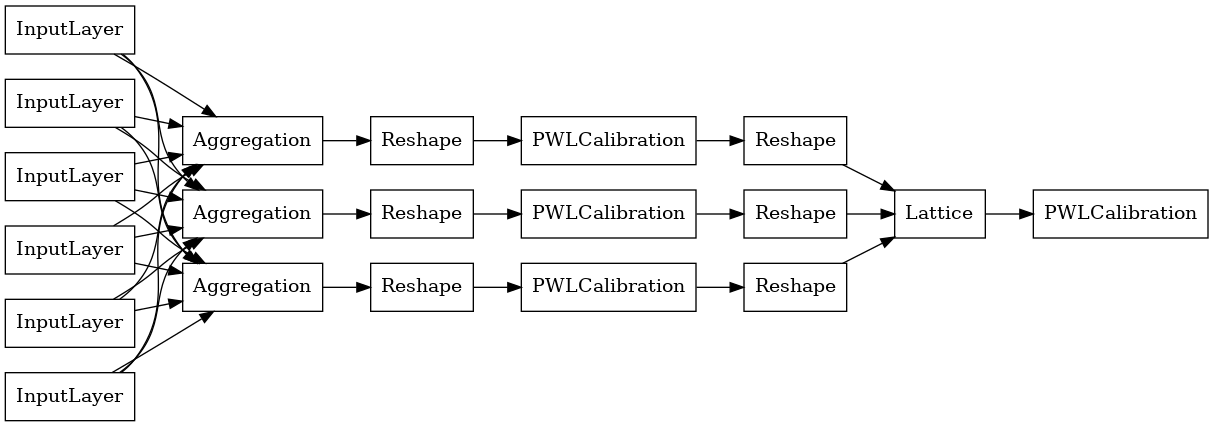

In [13]:
# Model config defines the model structure for the aggregate function model.
aggregate_function_model_config = tfl.configs.AggregateFunctionConfig(
    feature_configs=feature_configs,
    middle_dimension=MIDDLE_DIM,
    middle_lattice_size=MIDDLE_LATTICE_SIZE,
    middle_calibration=True,
    middle_calibration_num_keypoints=MIDDLE_KEYPOINTS,
    middle_monotonicity='increasing',
    output_min=min_label,
    output_max=max_label,
    output_calibration=True,
    output_calibration_num_keypoints=OUTPUT_KEYPOINTS,
    output_initialization=np.linspace(
        min_label, max_label, num=OUTPUT_KEYPOINTS))
# An AggregateFunction premade model constructed from the given model config.
aggregate_function_model = tfl.premade.AggregateFunction(
    aggregate_function_model_config)
# Let's plot our model.
tf.keras.utils.plot_model(
    aggregate_function_model, show_layer_names=False, rankdir='LR')

각 집계 레이어의 출력은 비 정형 입력에 대해 보정된 격자의 평균 출력입니다. 다음은 첫 번째 집계 레이어 내부에서 사용되는 모델입니다.

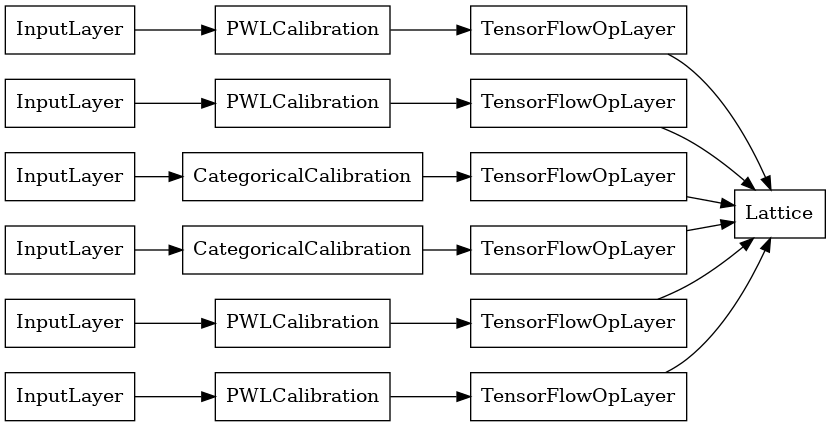

In [14]:
aggregation_layers = [
    layer for layer in aggregate_function_model.layers
    if isinstance(layer, tfl.layers.Aggregation)
]
tf.keras.utils.plot_model(
    aggregation_layers[0].model, show_layer_names=False, rankdir='LR')

이제 다른 [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)과 마찬가지로 모델을 데이터에 맞게 컴파일하고 적합하도록 맞춥니다.

In [15]:
aggregate_function_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))
aggregate_function_model.fit(
    train_xs, train_ys, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=False)

모델을 훈련한 후 테스트세트에서 평가할 수 있습니다.

In [16]:
print('Test Set Evaluation...')
print(aggregate_function_model.evaluate(test_xs, test_ys))

Test Set Evaluation...


1/7 [===>..........................] - ETA: 0s - loss: 107.0756

7/7 [==============================] - 0s 7ms/step - loss: 46.6563


46.65626525878906
